In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import simweights
import pickle
import os, sys
import re
import numpy as np

from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D

import matplotlib as mat
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors
import pandas as pd
import tables
import h5py
import math
from scipy.stats import mstats
import matplotlib as mpl
import matplotlib.font_manager as font_manager


In [3]:
sys.path.append("/data/user/tvaneede/GlobalFit/reco_processing/notebooks/weighting")
from weights import *
from utils import *
from selections import selection_mask
from fonts import *
from plot_utils import *

In [4]:
# Append the custom module path
sys.path.append("/data/user/tvaneede/GlobalFit/reco_processing")

# Import the datasets module
from datasets import datasets_taureco_iceprod_benchmark as datasets

# set the inputs
reco_versions = ["taureco_iceprod_benchmark_level8", "taureco_iceprod_benchmark_HESE", "evtgen_v4_rec_v9"]

# Dynamically select the desired dataset
simulation_datasets = {}
for reco_version in reco_versions: simulation_datasets[reco_version] = getattr(datasets, reco_version)

In [5]:
livetime_yr = 11.687
livetime_s  = livetime_yr * 365.25 * 24 * 3600 # 11.687 year

In [7]:
plotting_path = f"/data/user/tvaneede/GlobalFit/reco_processing/notebooks/benchmark_tau_reco_iceprod/compare_local_iceprod"
os.system(f"mkdir -p {plotting_path}")

0

In [8]:
# weight functions
gamma_astro = 2.87
per_flavor_norm = 2.12
AstroFluxModel_HESE = create_AstroFluxModel(per_flavor_norm=per_flavor_norm, gamma_astro=gamma_astro)

gamma_astro = 2.53
per_flavor_norm = 1.66
AstroFluxModel_cascade = create_AstroFluxModel(per_flavor_norm=per_flavor_norm, gamma_astro=gamma_astro)

In [9]:
def open_datasets( simulation_dataset, keys_to_merge ):

    # open the files
    for key in simulation_dataset:
        print(f"----- Extracting files for {key}")
        simulation_dataset[key]['hdf_file'] = pd.HDFStore(simulation_dataset[key]['hdf_file_path'],'r')
        simulation_dataset[key]['weighter'] = simweights.NuGenWeighter( simulation_dataset[key]['hdf_file'] ,nfiles=simulation_dataset[key]['nfiles'])

    # merging files
    for new_key in keys_to_merge:
        print(f"----- Creating new key {new_key}")
        simulation_dataset[new_key] = {}
        simulation_dataset[new_key]['variables'] = {}
        simulation_dataset[new_key]['weighter'] = None

        for key in keys_to_merge[new_key]:
            
            print(f"Using {key}")
            # merge the weighters
            if simulation_dataset[new_key]['weighter'] == None:
                simulation_dataset[new_key]['weighter'] = simulation_dataset[key]['weighter']
            else: simulation_dataset[new_key]['weighter'] += simulation_dataset[key]['weighter']

    return simulation_dataset



In [10]:
keys_to_merge = {}

keys_to_merge["evtgen_v4_rec_v9"] = {
    "NuE" : ["NuE_midE", "NuE_highE"],
    "NuMu" : ["NuMu_midE", "NuMu_highE"],
    "NuTau" : ["NuTau_midE", "NuTau_highE"],
    "NuAll" : ['NuE', "NuMu", "NuTau"],
}

keys_to_merge["taureco_iceprod_benchmark_HESE"] = {
    "NuE" : ["NuE_midE", "NuE_highE"],
    "NuMu" : ["NuMu_midE", "NuMu_highE"],
    "NuTau" : ["NuTau_midE", "NuTau_highE"],
    "NuAll" : ['NuE', "NuMu", "NuTau"],
}

keys_to_merge["taureco_iceprod_benchmark_level8"] = {
    "NuE" : ["NuE_lowE", "NuE_midE", "NuE_highE"],
    "NuMu" : ["NuMu_lowE","NuMu_midE", "NuMu_highE"],
    "NuTau" : ["NuTau_lowE","NuTau_midE", "NuTau_highE"],
    "NuAll" : ['NuE', "NuMu", "NuTau"],
}



In [11]:
for key in simulation_datasets: simulation_datasets[key] = open_datasets( simulation_datasets[key], keys_to_merge[key] )

----- Extracting files for NuTau_lowE
----- Extracting files for NuTau_midE
----- Extracting files for NuTau_highE
----- Extracting files for NuE_lowE
----- Extracting files for NuE_midE
----- Extracting files for NuE_highE
----- Extracting files for NuMu_lowE
----- Extracting files for NuMu_midE
----- Extracting files for NuMu_highE
----- Creating new key NuE
Using NuE_lowE
Using NuE_midE
Using NuE_highE
----- Creating new key NuMu
Using NuMu_lowE
Using NuMu_midE
Using NuMu_highE
----- Creating new key NuTau
Using NuTau_lowE
Using NuTau_midE
Using NuTau_highE
----- Creating new key NuAll
Using NuE
Using NuMu
Using NuTau
----- Extracting files for NuTau_midE
----- Extracting files for NuTau_highE
----- Extracting files for NuE_midE
----- Extracting files for NuE_highE
----- Extracting files for NuMu_midE
----- Extracting files for NuMu_highE
----- Creating new key NuE
Using NuE_midE
Using NuE_highE
----- Creating new key NuMu
Using NuMu_midE
Using NuMu_highE
----- Creating new key NuTa

In [12]:
dataset_label_dict = {
    "evtgen_v4_rec_v9" : "HESE local",
    "taureco_iceprod_benchmark_HESE" : "HESE",
    "taureco_iceprod_benchmark_level8" : "level8",
}

check if merging works now, seems to be fine

In [13]:
data = {}

for key in simulation_datasets:

    simulation_dataset = simulation_datasets[key]

    channel_data = {}

    for flavor in ['NuE', "NuMu", "NuTau"]:
        if "HESE" in key:
            weights = simulation_dataset[flavor]["weighter"].get_weights(AstroFluxModel_HESE) * livetime_s
        else:
            weights = simulation_dataset[flavor]["weighter"].get_weights(AstroFluxModel_cascade) * livetime_s
        rate = np.sum(weights)
        error = np.sqrt(np.sum(weights**2))
        channel_data[f"astro_{flavor}"] = f"{rate:.2f} ± {error:.2f}"

    # Conventional
    flavor = "NuAll"
    weights_conv = simulation_dataset[flavor]["weighter"].get_weights(generator_conv) * livetime_s
    rate_conv = np.sum(weights_conv)
    err_conv = np.sqrt(np.sum(weights_conv**2))
    channel_data["conv"] = f"{rate_conv:.3f} ± {err_conv:.3f}"

    # Prompt
    weights_prompt = simulation_dataset[flavor]["weighter"].get_weights(generator_pr) * livetime_s
    rate_prompt = np.sum(weights_prompt)
    err_prompt = np.sqrt(np.sum(weights_prompt**2))
    channel_data["prompt"] = f"{rate_prompt:.2f} ± {err_prompt:.2f}"

    data[ dataset_label_dict[key] ] = channel_data

# Create DataFrame
df = pd.DataFrame.from_dict(data, orient='index')

# Optional: specify column order
columns_order = [f"astro_{flavor}" for flavor in ['NuE', 'NuMu', 'NuTau']] + ["conv", "prompt"]
df = df[columns_order]

# Display as string table
print(df.to_string())

                 astro_NuE    astro_NuMu     astro_NuTau                 conv         prompt
level8      526.46 ± 11.66  96.91 ± 6.07  340.68 ± 10.87  10919.193 ± 665.323  282.05 ± 5.50
HESE          49.16 ± 4.58  20.31 ± 3.17    37.61 ± 5.74       31.596 ± 9.769   11.95 ± 0.94
HESE local    49.71 ± 0.59  21.07 ± 0.22    32.72 ± 0.32       41.078 ± 1.099   13.46 ± 0.10


In [16]:
def compare_dataset_flavor( base_key = "evtgen_v4_rec_v9",
                            base_var_key1 = "I3MCWeightDict", 
                            base_var_key2 = "PrimaryNeutrinoEnergy",
                            alt_key = "taureco_iceprod_benchmark_HESE",
                            alt_var_key1 = "I3MCWeightDict", 
                            alt_var_key2 = "PrimaryNeutrinoEnergy",
                            variable_name = "PrimaryNeutrinoEnergy [GeV]",
                            bins = np.geomspace(1e4, 1e6, 20),
                            xscale = "log", yscale = "log",
                            savename = "PrimaryNeutrinoEnergy"):


    # Compute bin centers for plotting
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Create 2 rows × 3 columns layout: top row = histograms, bottom row = ratios
    fig = plt.figure(figsize=(18, 8))  # Adjust height as needed
    gs = GridSpec(2, 3, height_ratios=[3, 1], hspace=0.05, wspace=0.3)

    fig.suptitle(rf"Variable {variable_name}", fontsize=16)

    # Create 3 upper and 3 lower subplots
    axes = [fig.add_subplot(gs[0, i]) for i in range(3)]        # ax0, ax1, ax2
    axes_ratio = [fig.add_subplot(gs[1, i], sharex=axes[i]) for i in range(3)]  # ax0_ratio, etc.

    # Now iterate over axes
    for ax, ax_ratio, flavor in zip(axes, axes_ratio, ["NuE", "NuMu", "NuTau"]):
        ax.set_title(rf"{flavor} astro, $\gamma = 2.87$, $\phi_0=2.12$, HESE")
        ax.set_xscale(xscale)
        ax.set_yscale(yscale)
        ax.set_ylabel(f"Rate / {livetime_yr} yr") 

        ax_ratio.set_xscale(xscale)
        ax_ratio.set_ylabel(f"Ratio { dataset_label_dict[alt_key]}" + "\n" + f"{dataset_label_dict[base_key]}")
        ax_ratio.set_xlabel(variable_name)
        ax_ratio.axhline(1, color="gray", linestyle="--", linewidth=1)

        var1 = simulation_datasets[base_key][flavor]["weighter"].get_column(base_var_key1, base_var_key2)
        var2 = simulation_datasets[alt_key][flavor]["weighter"].get_column(alt_var_key1, alt_var_key2)

        weights1 = simulation_datasets[base_key][flavor]["weighter"].get_weights(AstroFluxModel_HESE) * livetime_s
        weights2 = simulation_datasets[alt_key][flavor]["weighter"].get_weights(AstroFluxModel_HESE) * livetime_s

        # Compute histograms
        hist1, _  = np.histogram(var1,weights=weights1,bins=bins )
        hist2, _  = np.histogram(var2,weights=weights2,bins=bins )

        # compute errors
        hist1_error, _ = error_cal(bin_edges=bins,weights=weights1, data=var1)
        hist2_error, _ = error_cal(bin_edges=bins,weights=weights2, data=var2)

        # Compute ratios
        ratio = hist2 / hist1

        ax_ratio.plot(bin_centers, ratio, drawstyle="steps-mid", color="black")

        # Upper plot: histograms
        ax.hist(var1, 
                weights=weights1, 
                bins=bins, histtype="step", color="black", linestyle="-",label =  dataset_label_dict[base_key])
        ax.hist(var2, 
                weights=weights2, 
                bins=bins, histtype="step", color="C3", linestyle="-",label =  dataset_label_dict[alt_key])

        # Plot the error band
        ax.errorbar(x=bin_centers, y=hist1,yerr=hist1_error, color="black",fmt='o', markersize=2,capsize=5)
        ax.fill_between(bin_centers, hist2 - hist2_error, hist2 + hist2_error,step="mid", alpha=0.4, color="C3")

        # error of the ratio
        ratio_error = ratio * np.sqrt(
                (hist1_error / hist1)**2 + (hist2_error / hist2)**2
        )
        ratio_error[~np.isfinite(ratio_error)] = 0  # Set ratio error to 0 where hist1 or hist2 is 0
        ax_ratio.errorbar(bin_centers, ratio, yerr=ratio_error,fmt='o', color='black', markersize=2, capsize=5)

        # Improve layout
        plt.setp(ax.get_xticklabels(), visible=False)
        ax_ratio.set_ylim(0.5, 1.5)  # adjust as needed
        ax_ratio.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)
        ax.set_xlim(bins[0], bins[-1])

        ax.legend()

    plt.savefig(f"{plotting_path}/{savename}_flavor.pdf")

    plt.show()

Lets make some plots! 

First the true variables.

/tmp/ipykernel_31756/861850606.py:68: RuntimeWarning: invalid value encountered in divide
  (hist1_error / hist1)**2 + (hist2_error / hist2)**2


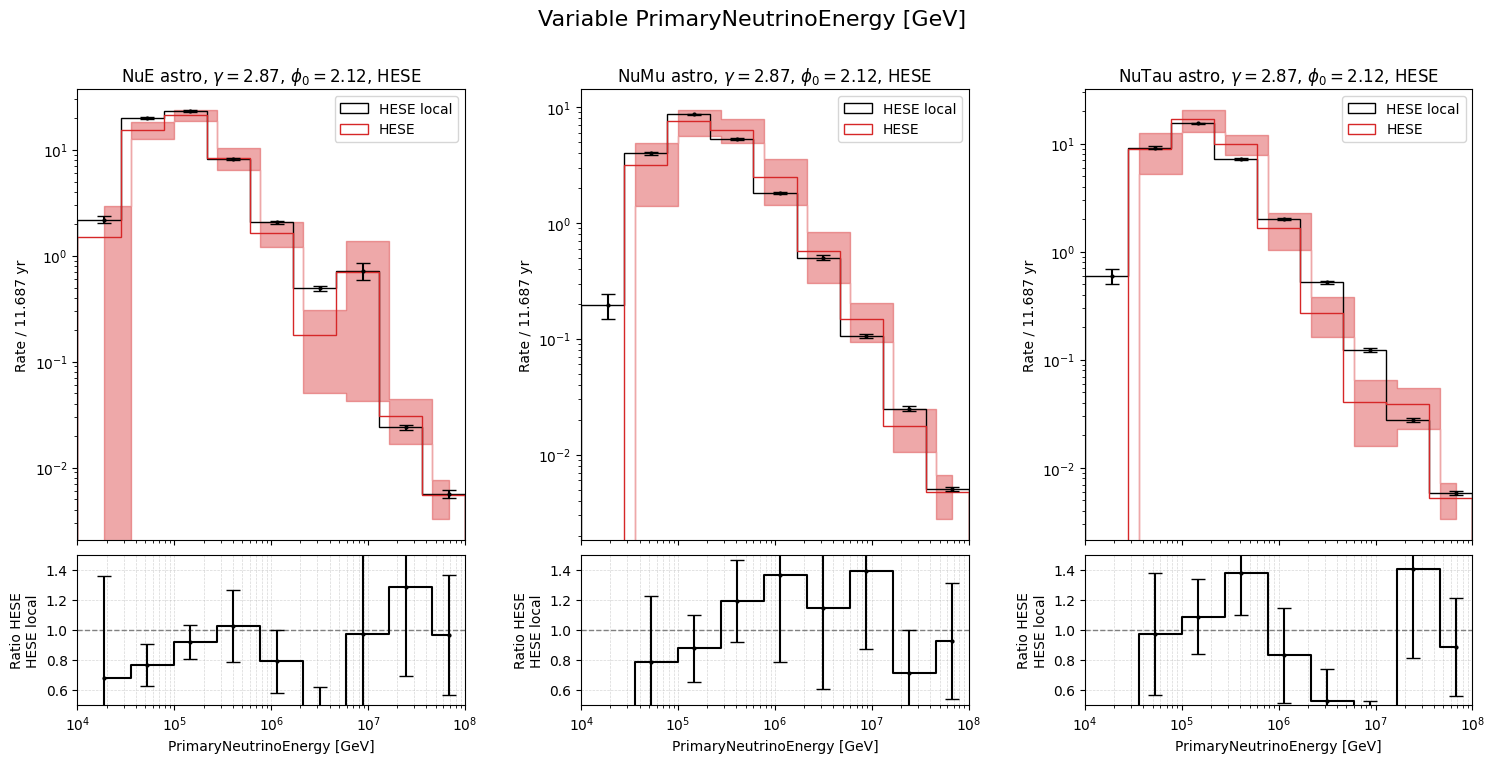

In [28]:
compare_dataset_flavor( base_key = "evtgen_v4_rec_v9", base_var_key1 = "I3MCWeightDict", base_var_key2 = "PrimaryNeutrinoEnergy",
                        alt_key  = "taureco_iceprod_benchmark_HESE", alt_var_key1 = "I3MCWeightDict", alt_var_key2 = "PrimaryNeutrinoEnergy",
                        variable_name = "PrimaryNeutrinoEnergy [GeV]", bins = np.geomspace(1e4, 1e8, 10), xscale = "log", yscale = "log", savename="PrimaryNeutrinoEnergy" )


/tmp/ipykernel_31756/861850606.py:68: RuntimeWarning: invalid value encountered in divide
  (hist1_error / hist1)**2 + (hist2_error / hist2)**2


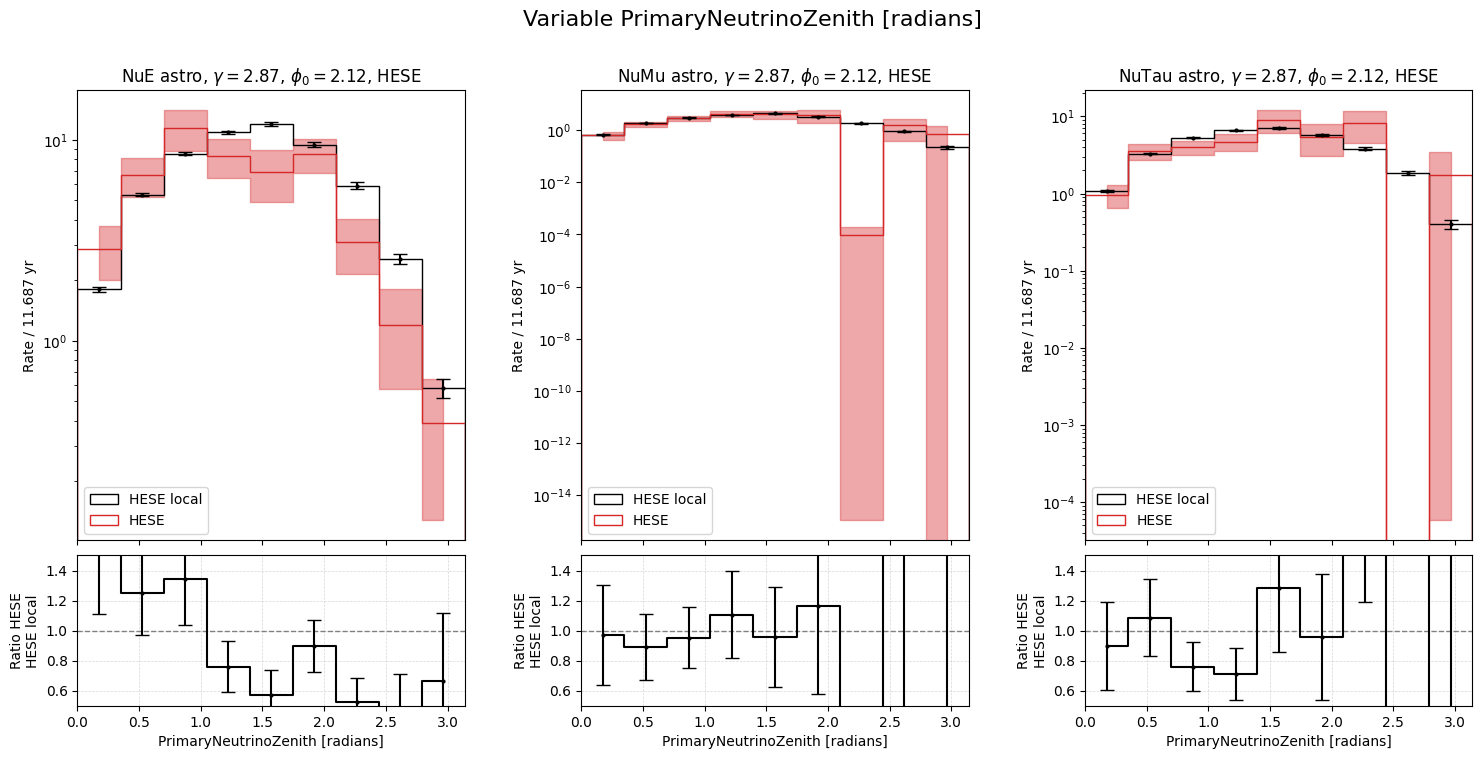

In [31]:
compare_dataset_flavor( base_key = "evtgen_v4_rec_v9", base_var_key1 = "I3MCWeightDict", base_var_key2 = "PrimaryNeutrinoZenith",
                        alt_key = "taureco_iceprod_benchmark_HESE", alt_var_key1 = "I3MCWeightDict", alt_var_key2 = "PrimaryNeutrinoZenith",
                        variable_name = "PrimaryNeutrinoZenith [radians]", bins = np.linspace(0, np.pi, 10), xscale = "linear", yscale = "log", savename="PrimaryNeutrinoZenith" )

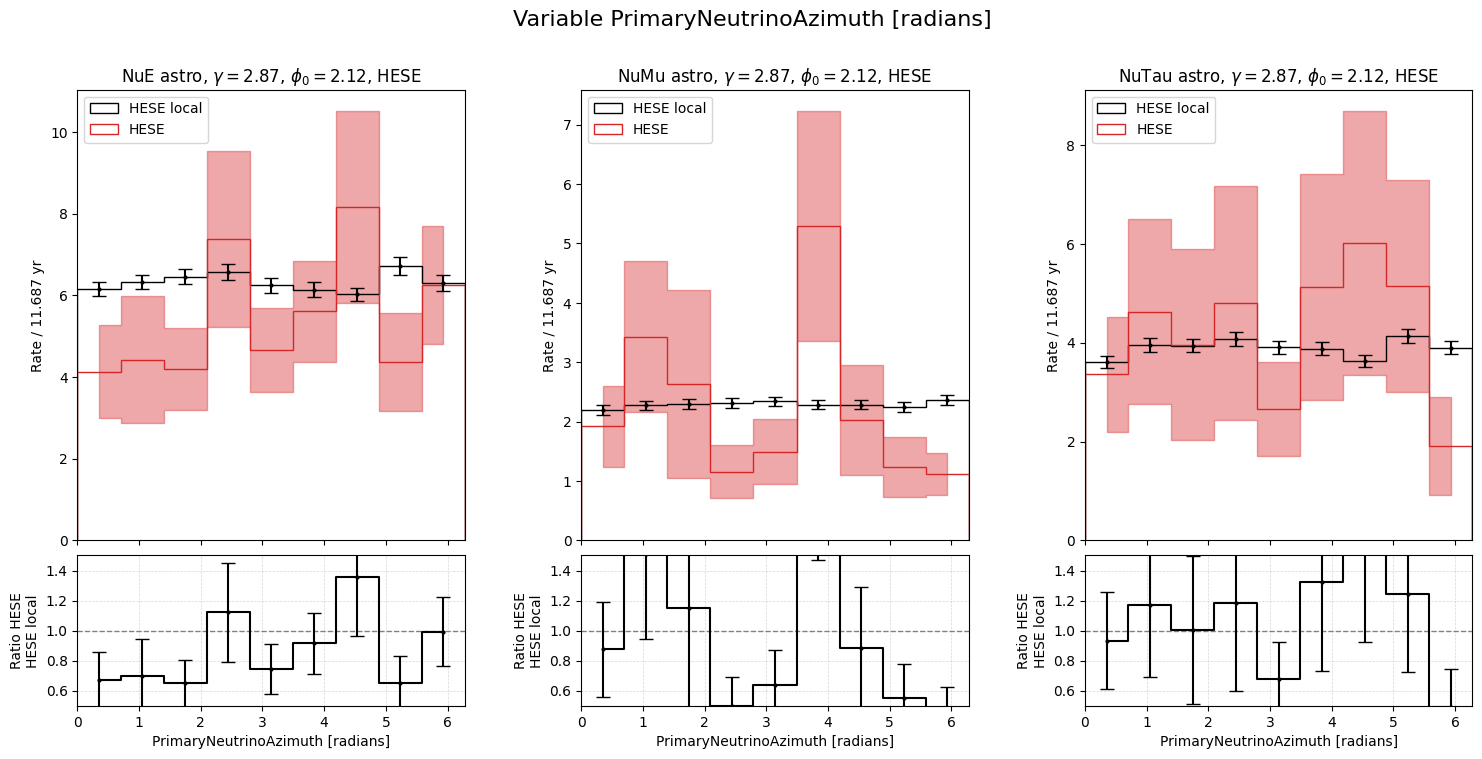

In [34]:
compare_dataset_flavor( base_key = "evtgen_v4_rec_v9", base_var_key1 = "I3MCWeightDict", base_var_key2 = "PrimaryNeutrinoAzimuth",
                          alt_key = "taureco_iceprod_benchmark_HESE", alt_var_key1 = "I3MCWeightDict", alt_var_key2 = "PrimaryNeutrinoAzimuth",
                          variable_name = "PrimaryNeutrinoAzimuth [radians]", bins = np.linspace(0, 2*np.pi, 10), xscale = "linear", yscale = "linear", savename="PrimaryNeutrinoAzimuth" )

Now lets do some reco variables!


/tmp/ipykernel_31756/861850606.py:68: RuntimeWarning: invalid value encountered in divide
  (hist1_error / hist1)**2 + (hist2_error / hist2)**2


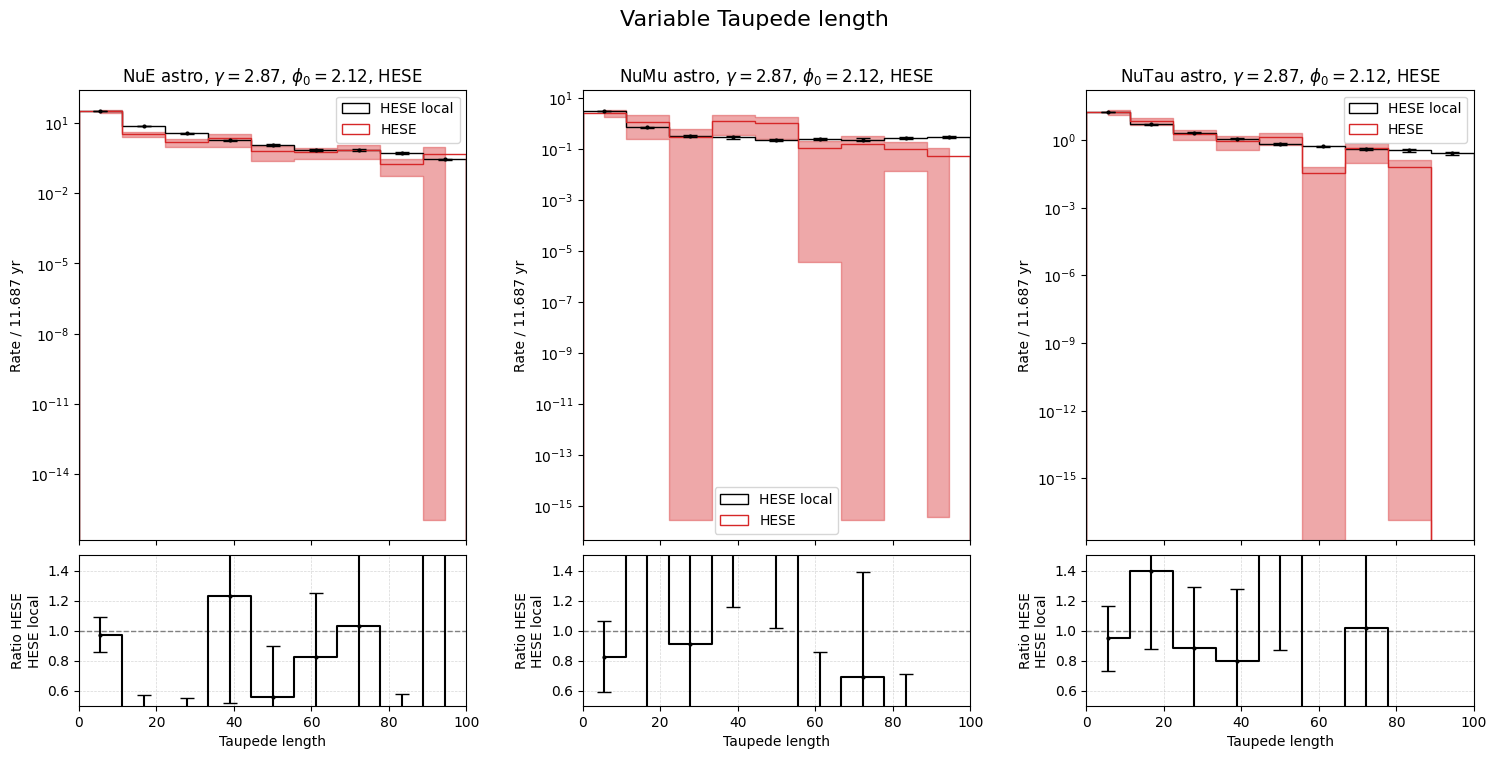

In [36]:
compare_dataset_flavor( base_key = "evtgen_v4_rec_v9", base_var_key1 = "TaupedeFit_iMIGRAD_PPB0", base_var_key2 = "length",
                        alt_key = "taureco_iceprod_benchmark_HESE", alt_var_key1 = "TaupedeFit_iMIGRAD_PPB0", alt_var_key2 = "length",
                        variable_name = "Taupede length", bins = np.linspace(0, 100, 10), xscale = "linear", yscale = "log", savename="TaupedeLength" )

/tmp/ipykernel_31756/861850606.py:68: RuntimeWarning: invalid value encountered in divide
  (hist1_error / hist1)**2 + (hist2_error / hist2)**2


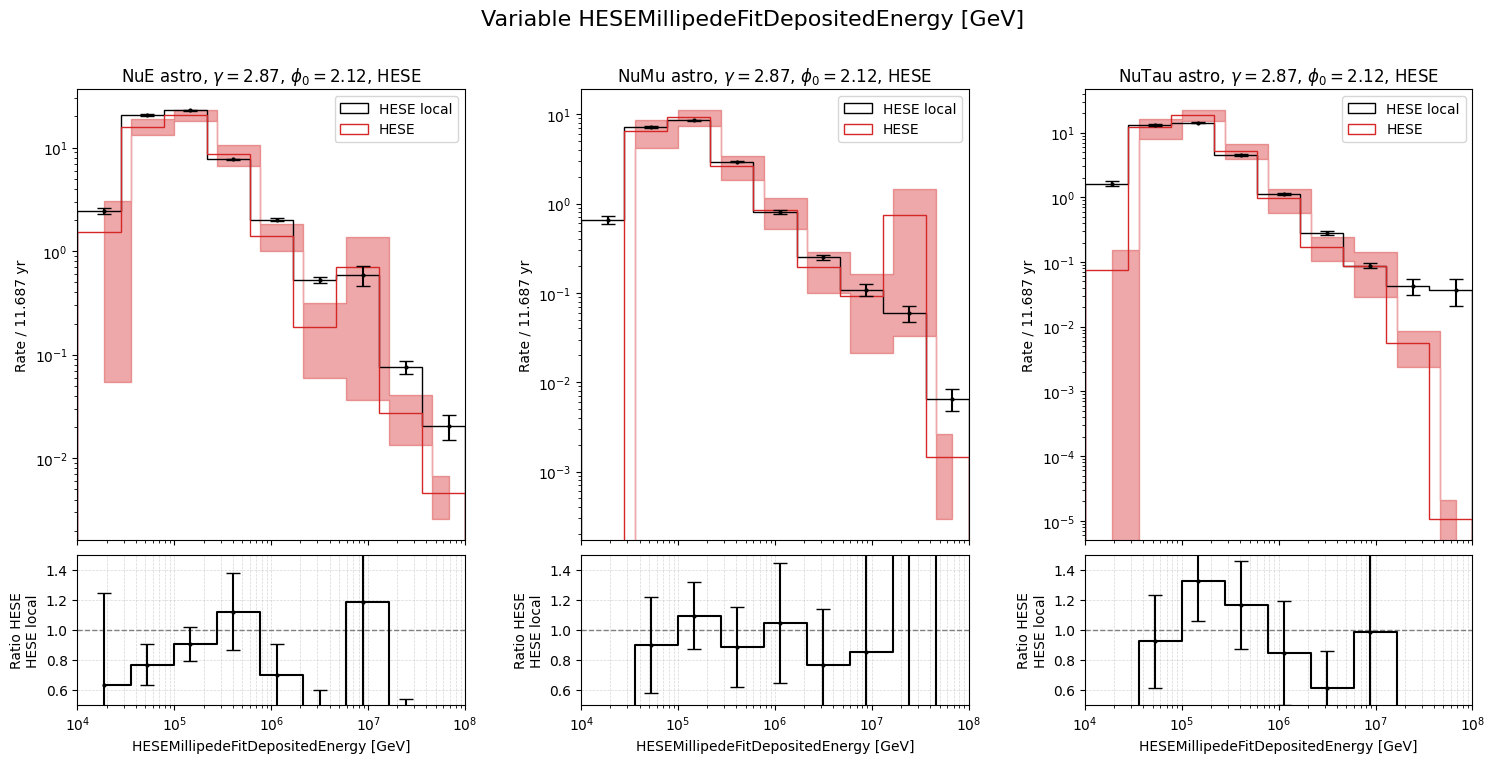

/tmp/ipykernel_31756/861850606.py:68: RuntimeWarning: invalid value encountered in divide
  (hist1_error / hist1)**2 + (hist2_error / hist2)**2


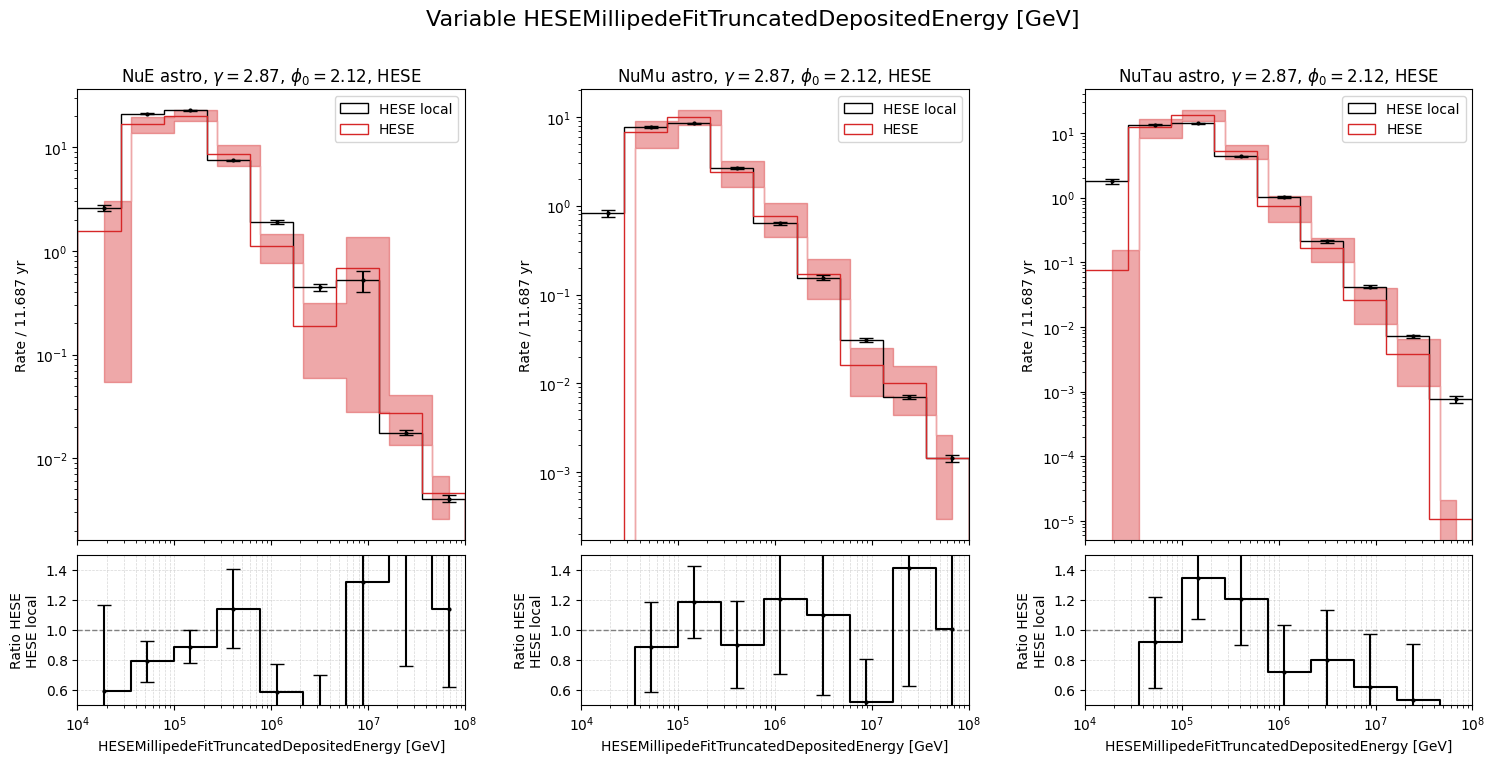

In [37]:
compare_dataset_flavor( base_key = "evtgen_v4_rec_v9", base_var_key1 = "HESEMillipedeFitDepositedEnergy", base_var_key2 = "value",
                          alt_key = "taureco_iceprod_benchmark_HESE", alt_var_key1 = "HESEMillipedeFitDepositedEnergy", alt_var_key2 = "value",
                          variable_name = "HESEMillipedeFitDepositedEnergy [GeV]", bins = np.geomspace(1e4, 1e8, 10), xscale = "log", yscale = "log", savename="HESEMillipedeFitDepositedEnergy" )


compare_dataset_flavor( base_key = "evtgen_v4_rec_v9", base_var_key1 = "HESEMillipedeFitTruncatedDepositedEnergy", base_var_key2 = "value",
                          alt_key = "taureco_iceprod_benchmark_HESE", alt_var_key1 = "HESEMillipedeFitTruncatedDepositedEnergy", alt_var_key2 = "value",
                          variable_name = "HESEMillipedeFitTruncatedDepositedEnergy [GeV]", bins = np.geomspace(1e4, 1e8, 10), xscale = "log", yscale = "log", savename="HESEMillipedeFitTruncatedDepositedEnergy" )

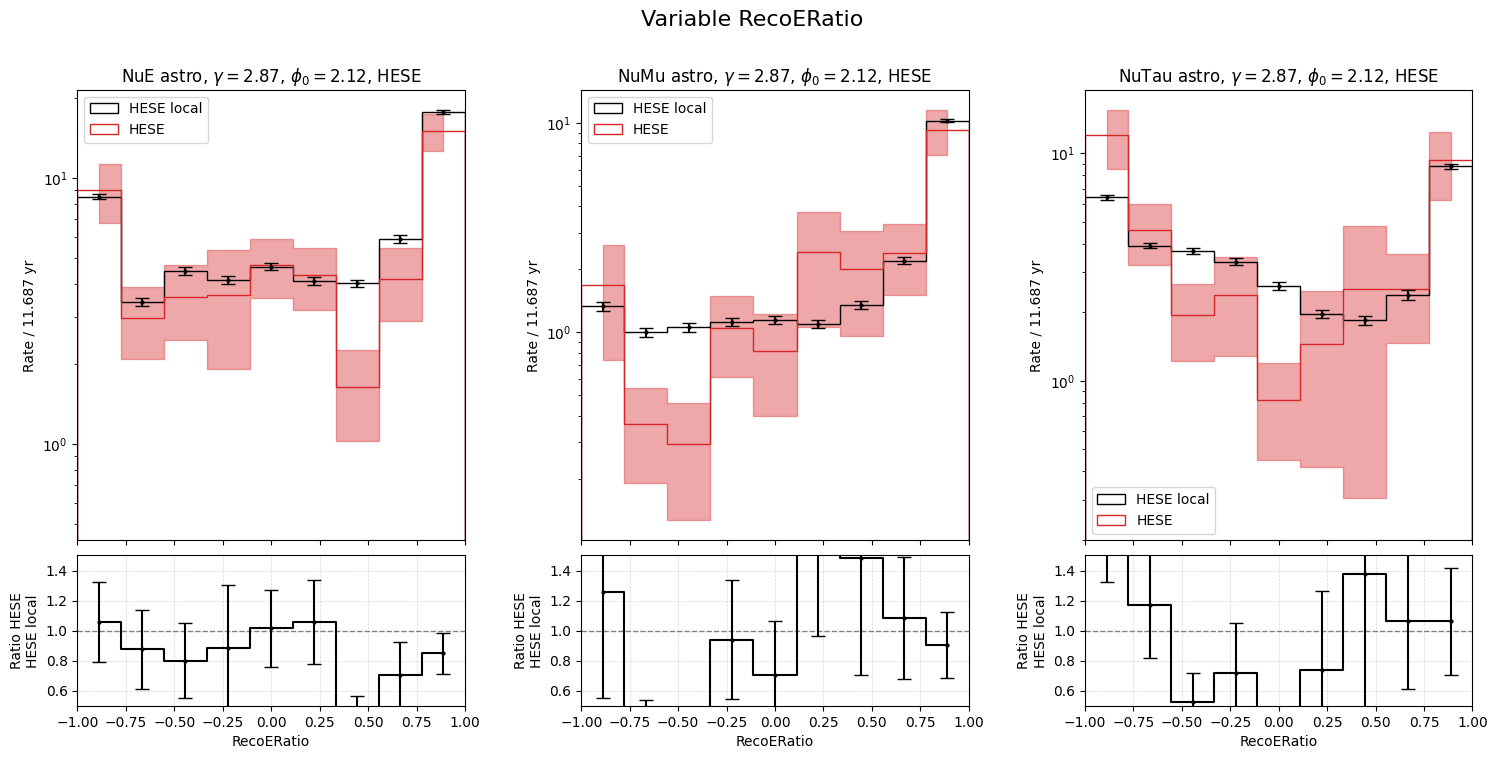

In [38]:
compare_dataset_flavor( base_key = "evtgen_v4_rec_v9", base_var_key1 = "RecoERatio", base_var_key2 = "value",
                          alt_key = "taureco_iceprod_benchmark_HESE", alt_var_key1 = "RecoERatio", alt_var_key2 = "value",
                          variable_name = "RecoERatio", bins = np.linspace(-1, 1, 10), xscale = "linear", yscale = "log", savename="RecoERatio" )

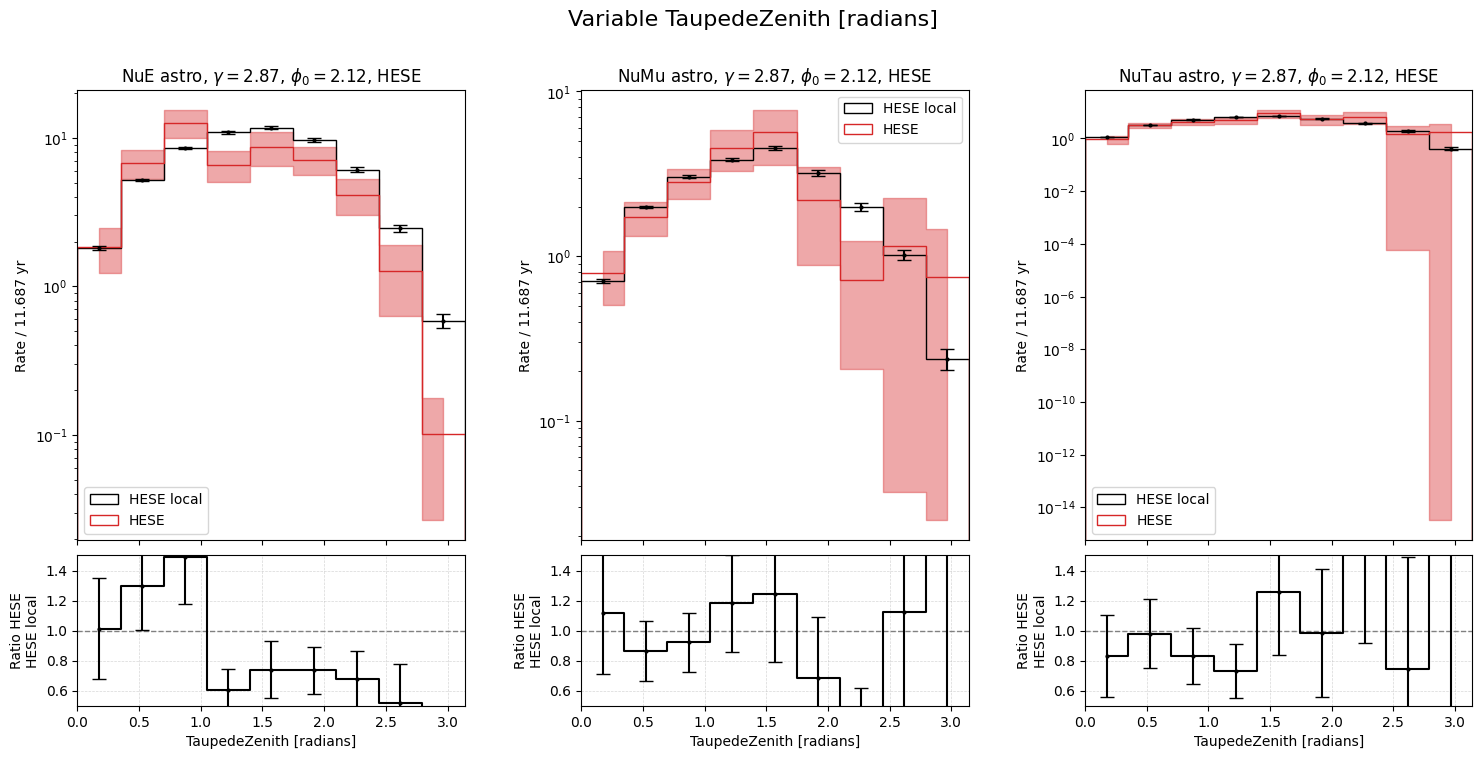

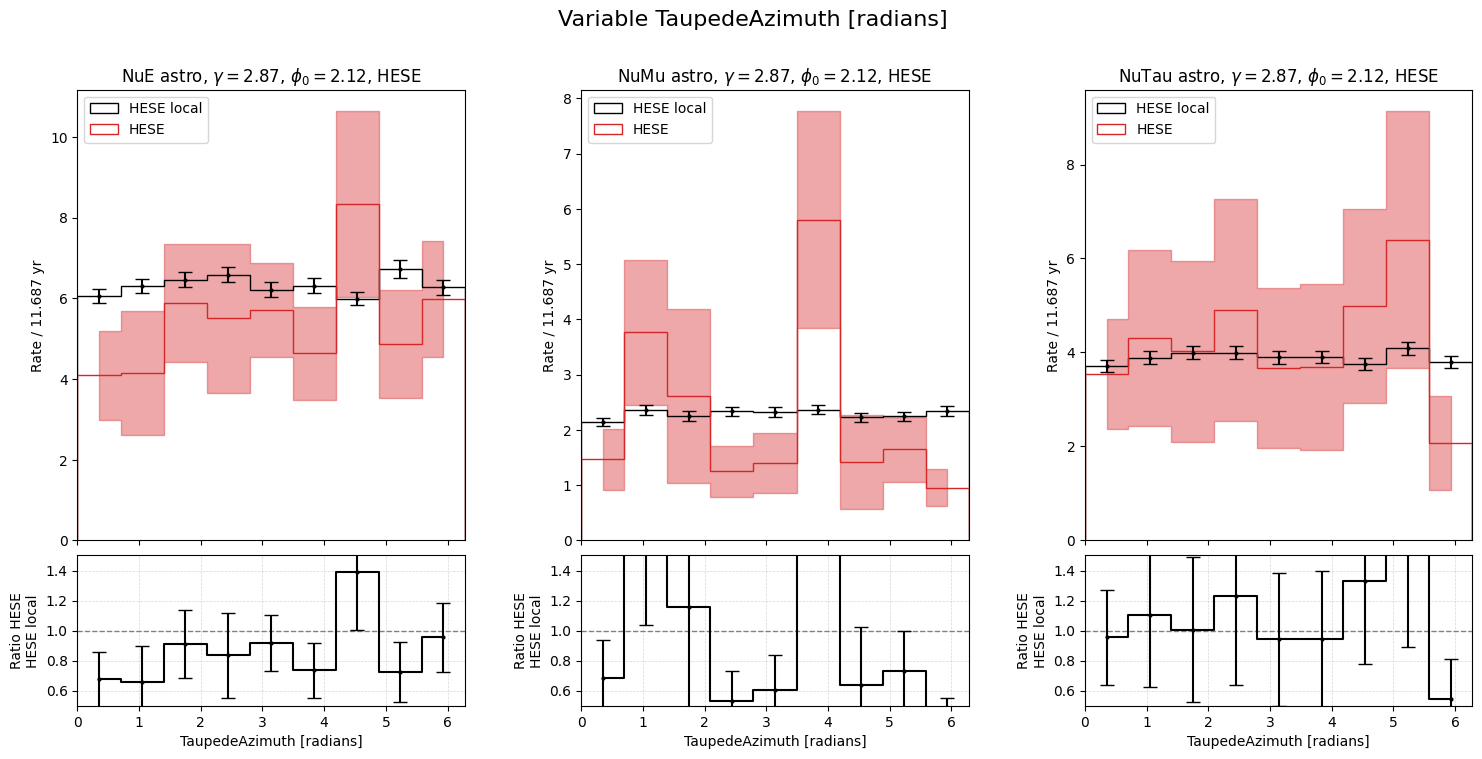

/tmp/ipykernel_31756/861850606.py:68: RuntimeWarning: invalid value encountered in divide
  (hist1_error / hist1)**2 + (hist2_error / hist2)**2


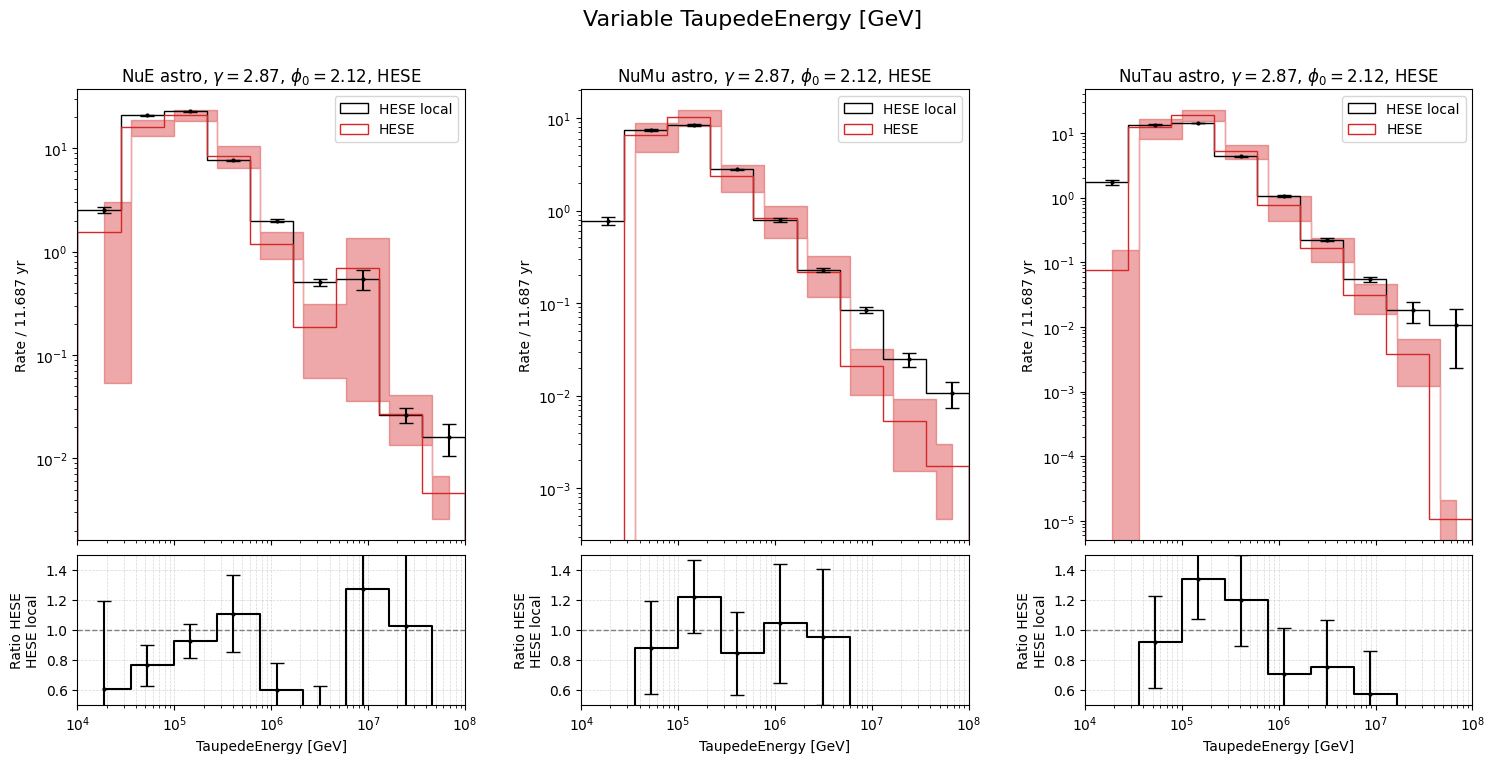

In [40]:
compare_dataset_flavor( base_key = "evtgen_v4_rec_v9", base_var_key1 = "TaupedeFit_iMIGRAD_PPB0", base_var_key2 = "zenith",
                          alt_key = "taureco_iceprod_benchmark_HESE", alt_var_key1 = "TaupedeFit_iMIGRAD_PPB0", alt_var_key2 = "zenith",
                          variable_name = "TaupedeZenith [radians]", bins = np.linspace(0, np.pi, 10), xscale = "linear", yscale = "log", savename="TaupedeZenith" )

compare_dataset_flavor( base_key = "evtgen_v4_rec_v9", base_var_key1 = "TaupedeFit_iMIGRAD_PPB0", base_var_key2 = "azimuth",
                          alt_key = "taureco_iceprod_benchmark_HESE", alt_var_key1 = "TaupedeFit_iMIGRAD_PPB0", alt_var_key2 = "azimuth",
                          variable_name = "TaupedeAzimuth [radians]", bins = np.linspace(0, 2*np.pi, 10), xscale = "linear", yscale = "linear", savename="TaupedeAzimuth" )

compare_dataset_flavor( base_key = "evtgen_v4_rec_v9", base_var_key1 = "TaupedeFit_iMIGRAD_PPB0", base_var_key2 = "energy",
                          alt_key = "taureco_iceprod_benchmark_HESE", alt_var_key1 = "TaupedeFit_iMIGRAD_PPB0", alt_var_key2 = "energy",
                          variable_name = "TaupedeEnergy [GeV]", bins = np.geomspace(1e4, 1e8, 10), xscale = "log", yscale = "log", savename="TaupedeEnergy" )


/tmp/ipykernel_31756/861850606.py:68: RuntimeWarning: invalid value encountered in divide
  (hist1_error / hist1)**2 + (hist2_error / hist2)**2


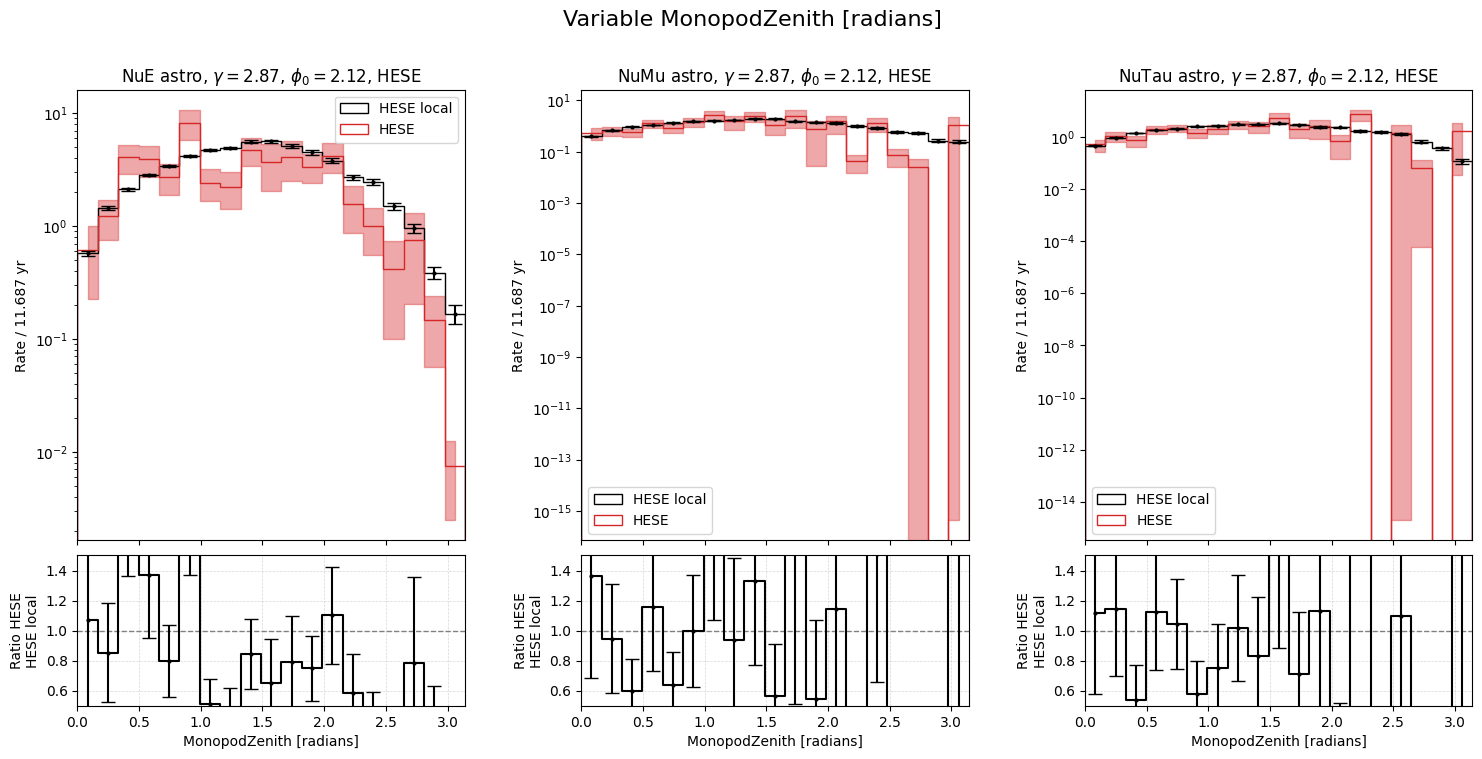

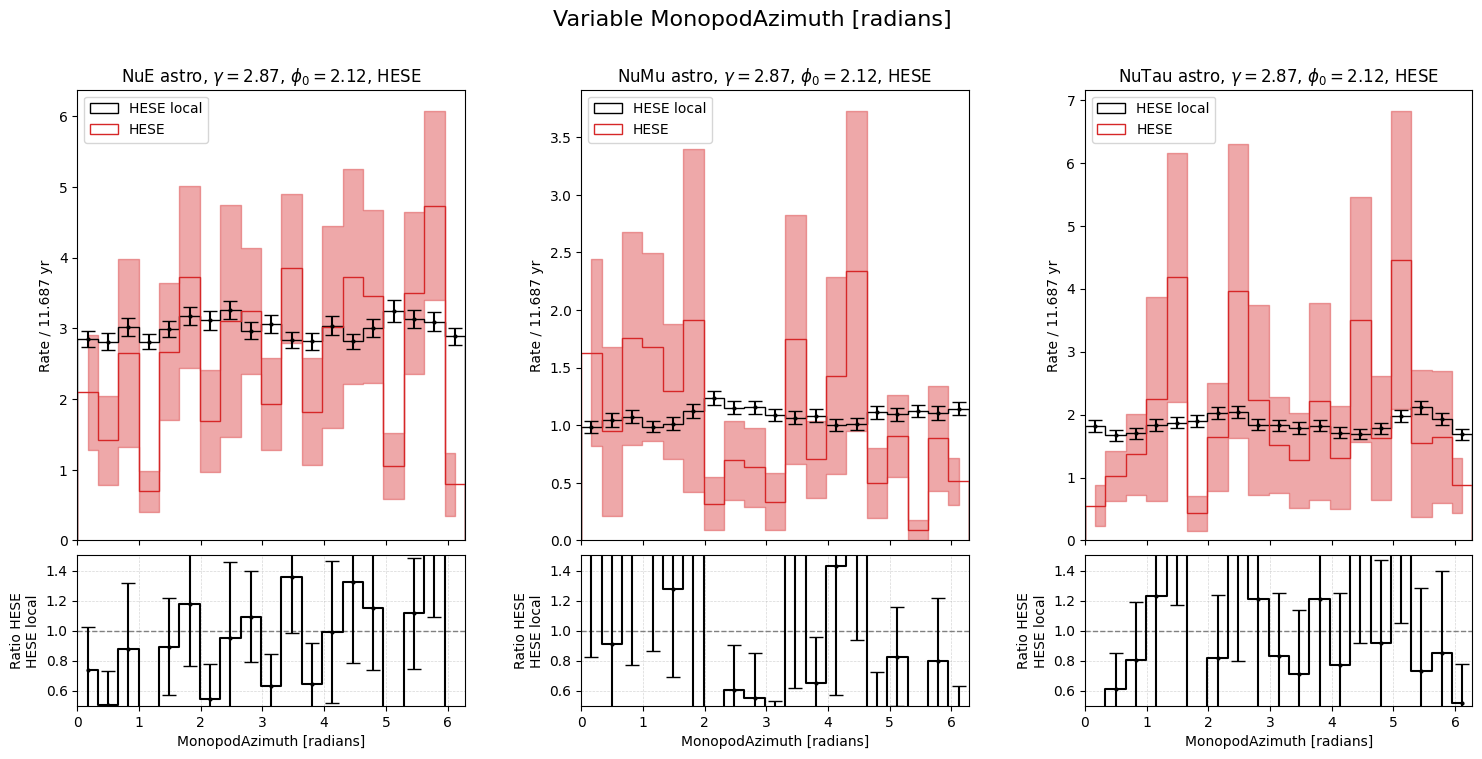

/tmp/ipykernel_31756/861850606.py:68: RuntimeWarning: invalid value encountered in divide
  (hist1_error / hist1)**2 + (hist2_error / hist2)**2


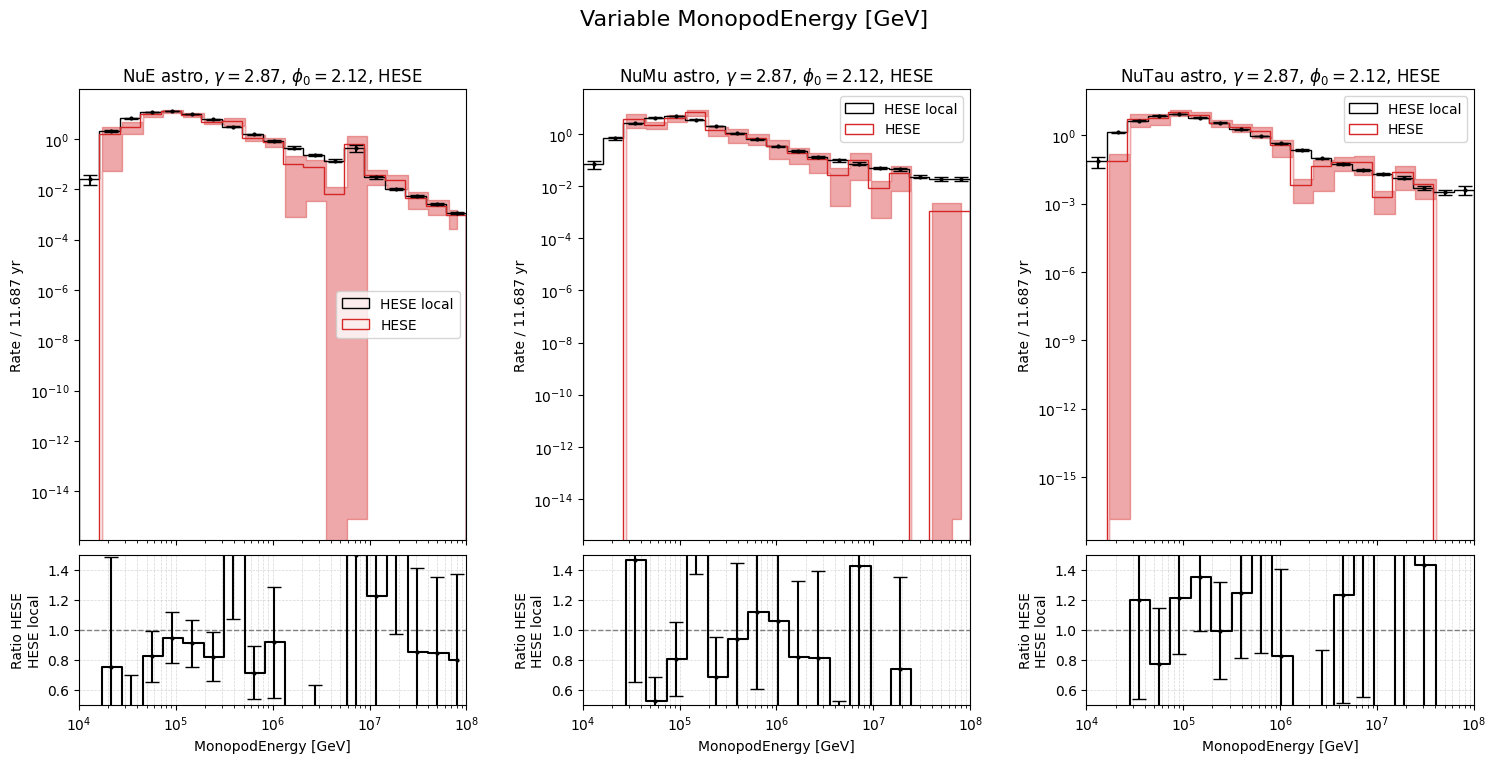

In [41]:
compare_dataset_flavor( base_key = "evtgen_v4_rec_v9", base_var_key1 = "MonopodFit_iMIGRAD_PPB0", base_var_key2 = "zenith",
                          alt_key = "taureco_iceprod_benchmark_HESE", alt_var_key1 = "MonopodFit_iMIGRAD_PPB0", alt_var_key2 = "zenith",
                          variable_name = "MonopodZenith [radians]", bins = np.linspace(0, np.pi, 20), xscale = "linear", yscale = "log", savename="MonopodZenith" )

compare_dataset_flavor( base_key = "evtgen_v4_rec_v9", base_var_key1 = "MonopodFit_iMIGRAD_PPB0", base_var_key2 = "azimuth",
                          alt_key = "taureco_iceprod_benchmark_HESE", alt_var_key1 = "MonopodFit_iMIGRAD_PPB0", alt_var_key2 = "azimuth",
                          variable_name = "MonopodAzimuth [radians]", bins = np.linspace(0, 2*np.pi, 20), xscale = "linear", yscale = "linear", savename="MonopodAzimuth" )

compare_dataset_flavor( base_key = "evtgen_v4_rec_v9", base_var_key1 = "MonopodFit_iMIGRAD_PPB0", base_var_key2 = "energy",
                          alt_key = "taureco_iceprod_benchmark_HESE", alt_var_key1 = "MonopodFit_iMIGRAD_PPB0", alt_var_key2 = "energy",
                          variable_name = "MonopodEnergy [GeV]", bins = np.geomspace(1e4, 1e8, 20), xscale = "log", yscale = "log", savename="MonopodEnergy" )

/tmp/ipykernel_45199/888270130.py:71: RuntimeWarning: invalid value encountered in divide
  (hist1_error / hist1)**2 + (hist2_error / hist2)**2


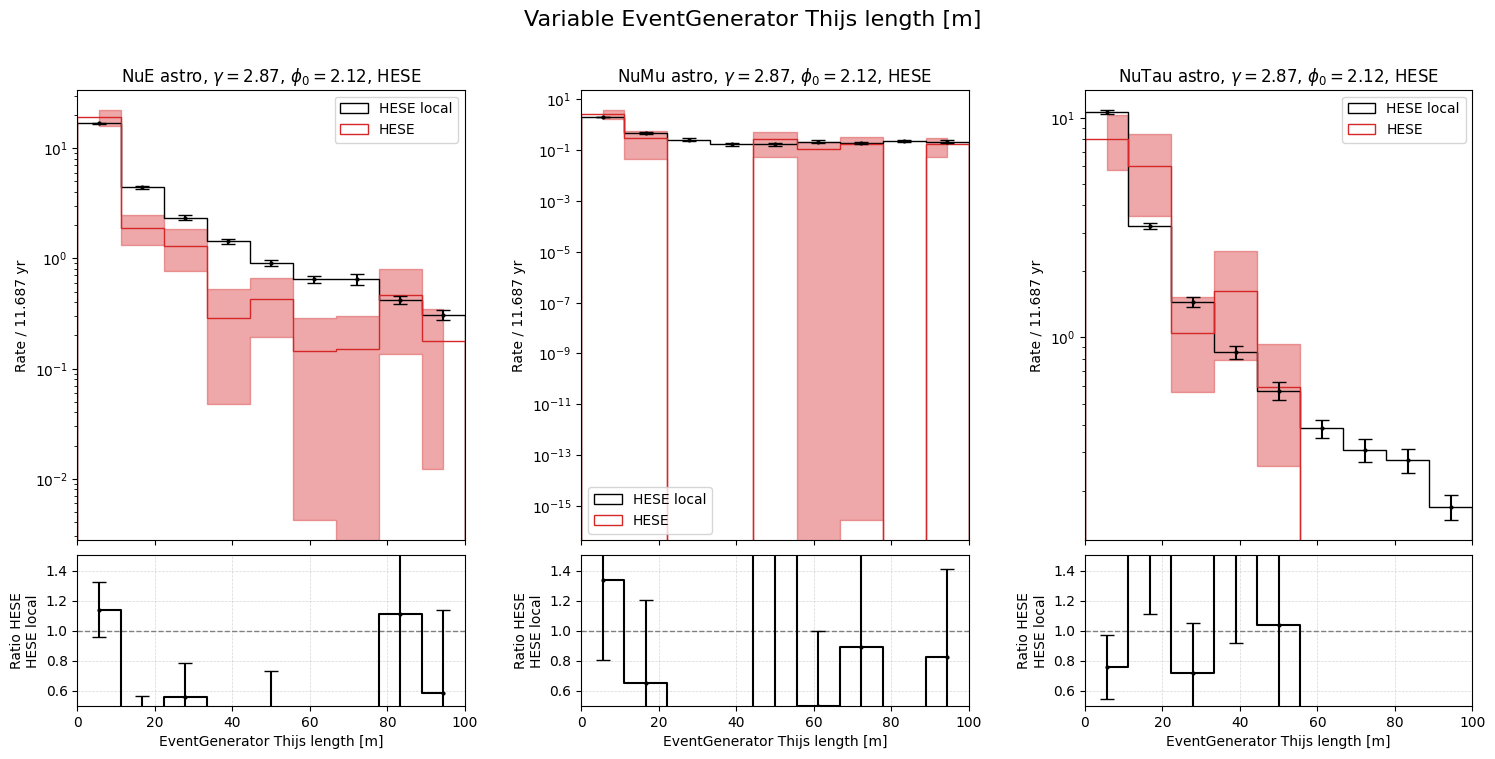

/tmp/ipykernel_45199/888270130.py:71: RuntimeWarning: invalid value encountered in divide
  (hist1_error / hist1)**2 + (hist2_error / hist2)**2


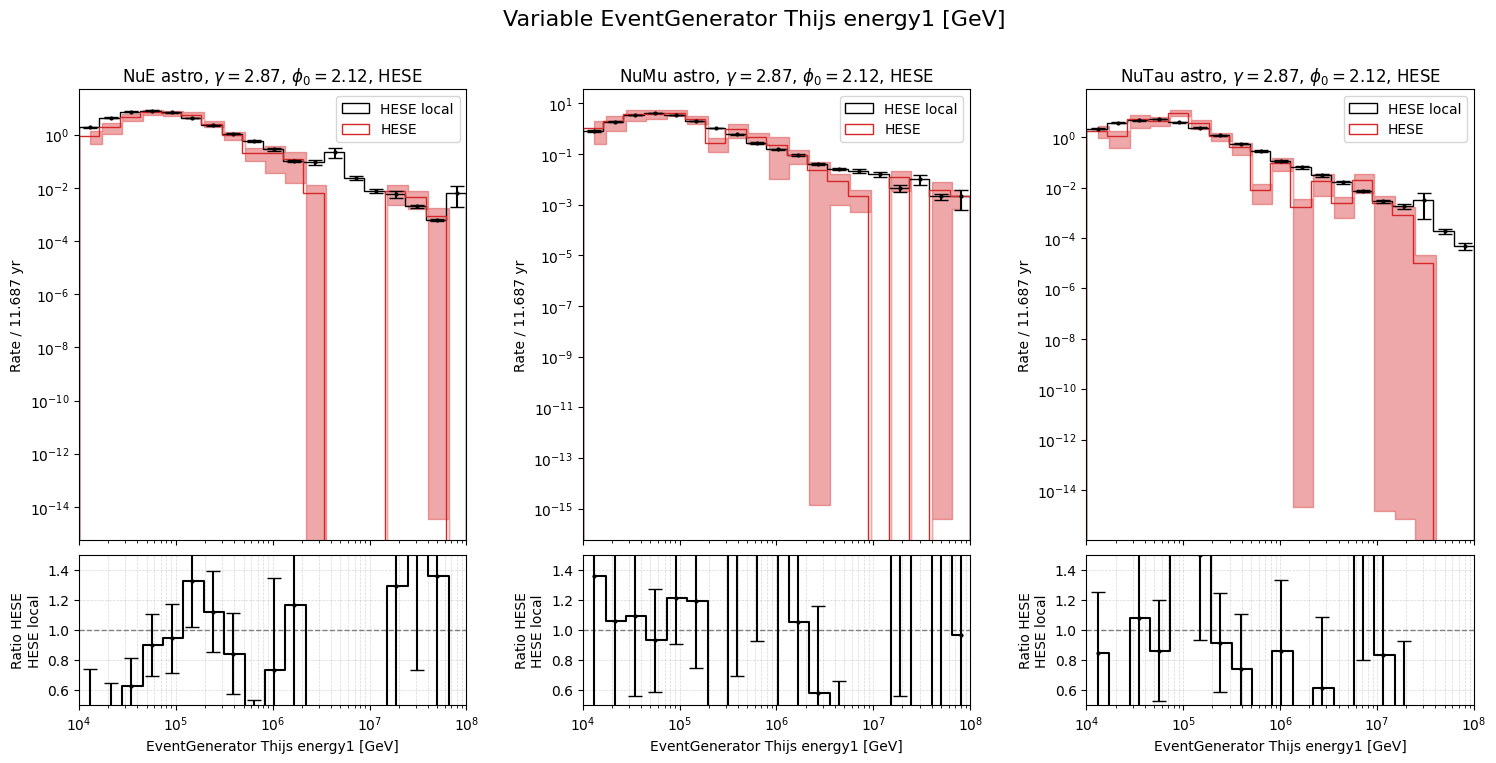

/tmp/ipykernel_45199/888270130.py:71: RuntimeWarning: invalid value encountered in divide
  (hist1_error / hist1)**2 + (hist2_error / hist2)**2


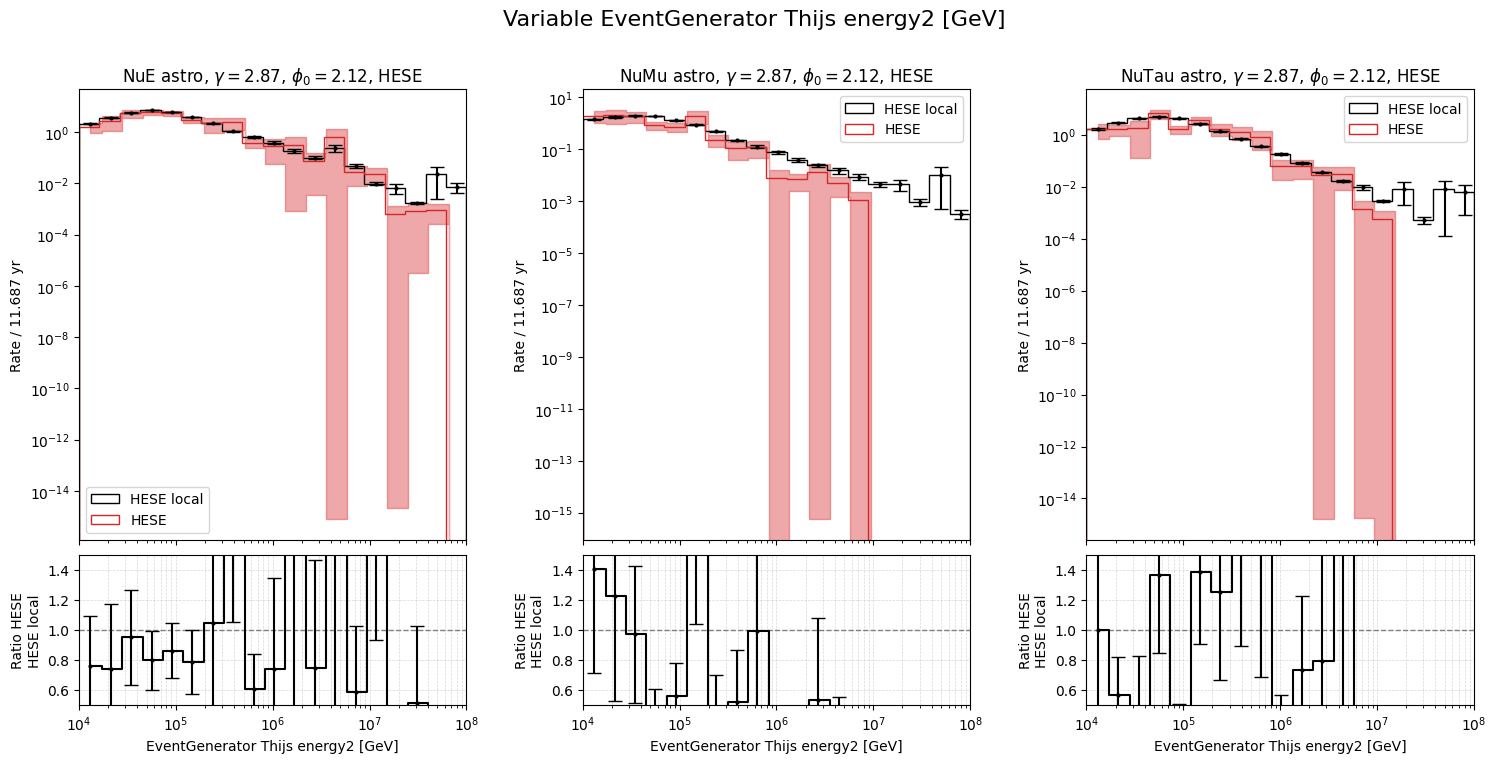

In [18]:
compare_dataset_flavor( base_key = "evtgen_v4_rec_v9", base_var_key1 = "EventGeneratorDC_Thijs", base_var_key2 = "cascade_cascade_00001_distance",
                          alt_key = "taureco_iceprod_benchmark_HESE", alt_var_key1 = "EventGeneratorDC_Thijs", alt_var_key2 = "cascade_cascade_00001_distance",
                          variable_name = "EventGenerator Thijs length [m]", bins = np.linspace(0, 100, 10), xscale = "linear", yscale = "log", savename="EventGeneratorDC_ThijsLength" )

compare_dataset_flavor( base_key = "evtgen_v4_rec_v9", base_var_key1 = "EventGeneratorDC_Thijs", base_var_key2 = "cascade_energy",
                          alt_key = "taureco_iceprod_benchmark_HESE", alt_var_key1 = "EventGeneratorDC_Thijs", alt_var_key2 = "cascade_energy",
                          variable_name = "EventGenerator Thijs energy1 [GeV]", bins = np.geomspace(1e4, 1e8, 20), xscale = "log", yscale = "log", savename="EventGeneratorDC_ThijsE1" )

compare_dataset_flavor( base_key = "evtgen_v4_rec_v9", base_var_key1 = "EventGeneratorDC_Thijs", base_var_key2 = "cascade_cascade_00001_energy",
                          alt_key = "taureco_iceprod_benchmark_HESE", alt_var_key1 = "EventGeneratorDC_Thijs", alt_var_key2 = "cascade_cascade_00001_energy",
                          variable_name = "EventGenerator Thijs energy2 [GeV]", bins = np.geomspace(1e4, 1e8, 20), xscale = "log", yscale = "log", savename="EventGeneratorDC_ThijsE2" )

/tmp/ipykernel_45199/888270130.py:71: RuntimeWarning: invalid value encountered in divide
  (hist1_error / hist1)**2 + (hist2_error / hist2)**2


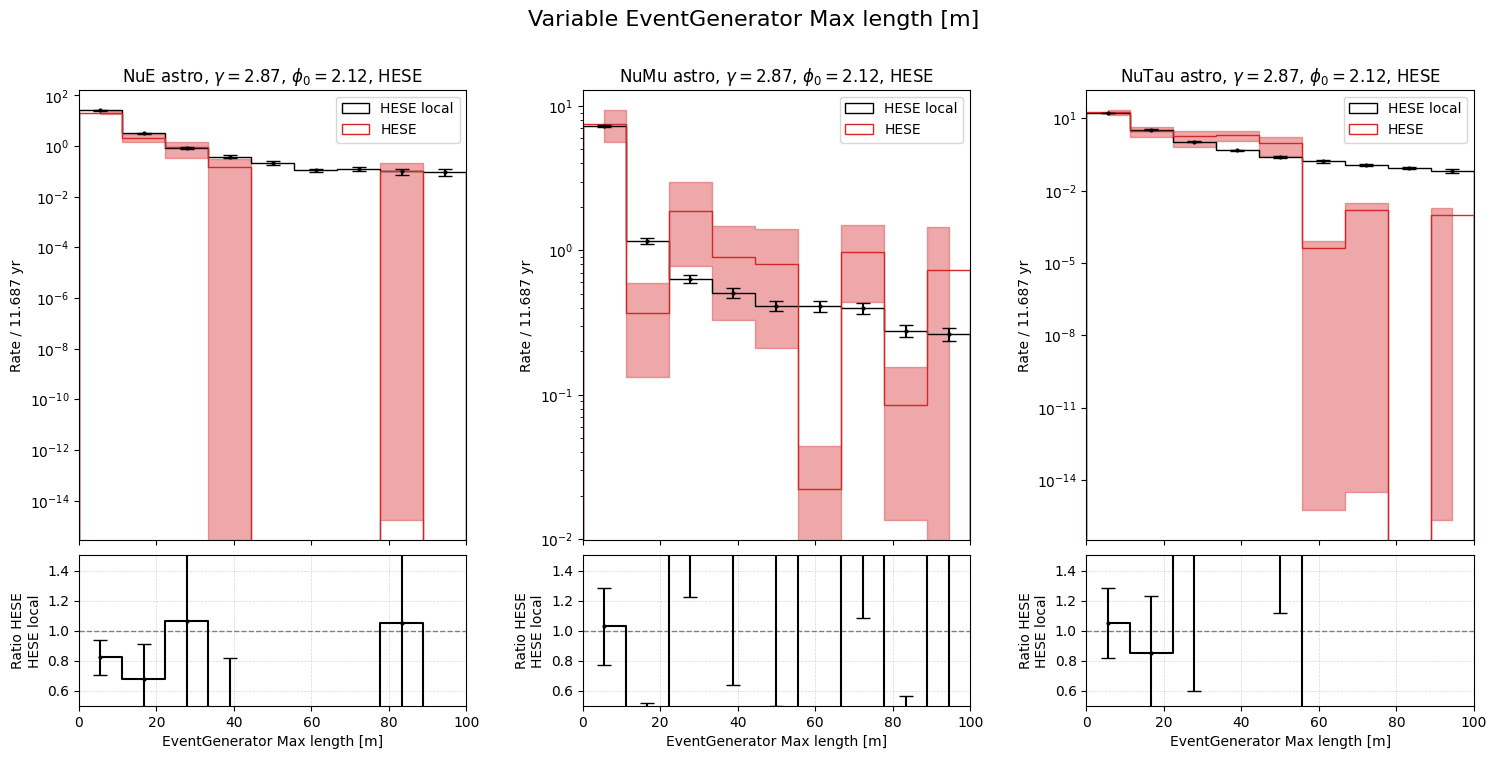

/tmp/ipykernel_45199/888270130.py:71: RuntimeWarning: invalid value encountered in divide
  (hist1_error / hist1)**2 + (hist2_error / hist2)**2


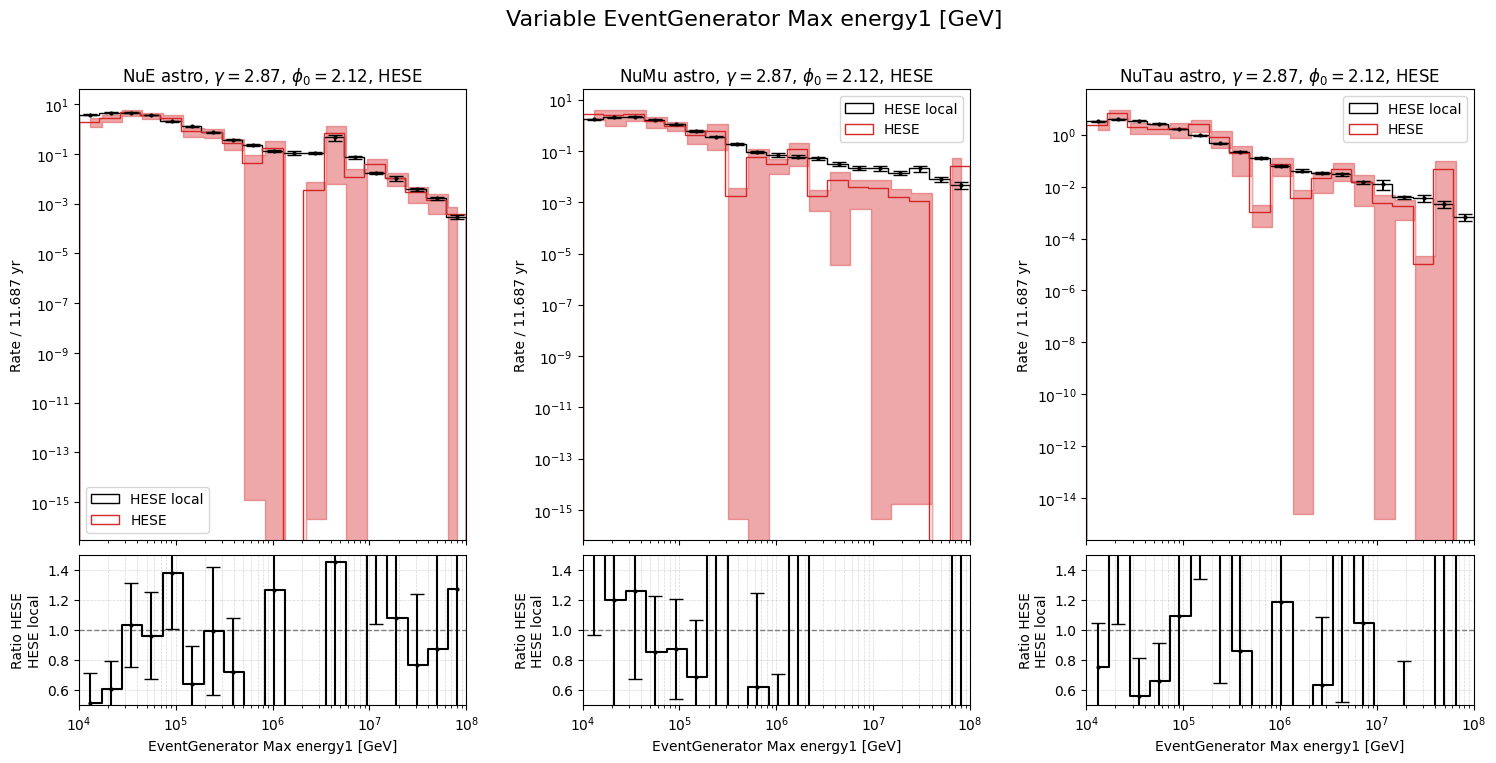

/tmp/ipykernel_45199/888270130.py:71: RuntimeWarning: invalid value encountered in divide
  (hist1_error / hist1)**2 + (hist2_error / hist2)**2


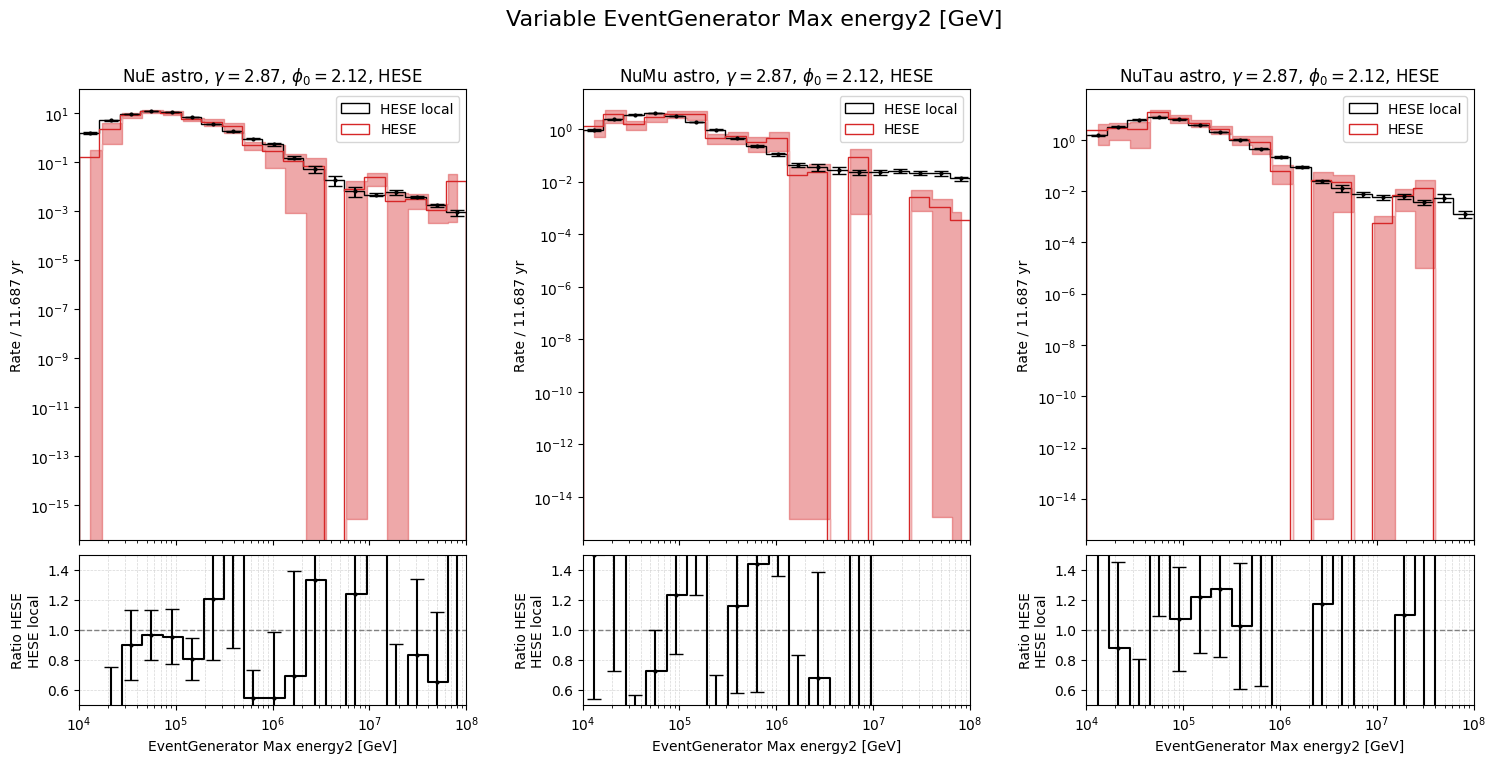

In [19]:
compare_dataset_flavor( base_key = "evtgen_v4_rec_v9", base_var_key1 = "EventGeneratorDC_Max", base_var_key2 = "cascade_cascade_00001_distance",
                          alt_key = "taureco_iceprod_benchmark_HESE", alt_var_key1 = "EventGeneratorDC_Max", alt_var_key2 = "cascade_cascade_00001_distance",
                          variable_name = "EventGenerator Max length [m]", bins = np.linspace(0, 100, 10), xscale = "linear", yscale = "log", savename="EventGeneratorDC_MaxLength" )

compare_dataset_flavor( base_key = "evtgen_v4_rec_v9", base_var_key1 = "EventGeneratorDC_Max", base_var_key2 = "cascade_energy",
                          alt_key = "taureco_iceprod_benchmark_HESE", alt_var_key1 = "EventGeneratorDC_Max", alt_var_key2 = "cascade_energy",
                          variable_name = "EventGenerator Max energy1 [GeV]", bins = np.geomspace(1e4, 1e8, 20), xscale = "log", yscale = "log", savename="EventGeneratorDC_MaxE1" )

compare_dataset_flavor( base_key = "evtgen_v4_rec_v9", base_var_key1 = "EventGeneratorDC_Max", base_var_key2 = "cascade_cascade_00001_energy",
                          alt_key = "taureco_iceprod_benchmark_HESE", alt_var_key1 = "EventGeneratorDC_Max", alt_var_key2 = "cascade_cascade_00001_energy",
                          variable_name = "EventGenerator Max energy2 [GeV]", bins = np.geomspace(1e4, 1e8, 20), xscale = "log", yscale = "log", savename="EventGeneratorDC_MaxE2" )